# RaceOracle - Wyrocznia Wrocławska

In [ ]:
# pip install --quiet boto3==1.35.99

In [1]:
import pandas as pd
from pycaret.regression import *
# import boto3
from dotenv import load_dotenv
import os

load_dotenv()

# BUCKET_NAME = "m-kij"

True

In [2]:
# Utworzenie klienta s3
# s3 = boto3.client(
#     "s3",
#     # aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
#     # aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
#     # Endpoint jest potrzebny dlatego że używamy chmury innej niż AWS 
#     # endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"), 
#     # Gdybyśmy używali AWS to musielibyśmy natomiast podać region
#     #region_name='eu-central-1'
# )

In [2]:
df = pd.read_csv('halfmarathon_wroclaw_2023__final.csv', sep=';')
# do_df.to_csv(f"s3://{BUCKET_NAME}/halfmarathon_wroclaw_2023.csv")

# Wczytanie z DO pliku csv do df
# df = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathon_wroclaw_2023__final.csv", sep=';')
df.head()


,Miejsce,Numer startowy,Imię,Nazwisko,Miasto,Kraj,Drużyna,Płeć,Płeć Miejsce,Kategoria wiekowa,...,10 km Tempo,15 km Czas,15 km Miejsce Open,15 km Tempo,20 km Czas,20 km Miejsce Open,20 km Tempo,Tempo Stabilność,Czas,Tempo
0,1.0,1787,TOMASZ,GRYCKO,NaN,POL,UKS BLIZA WŁADYSŁAWOWO,M,1.0,M30,...,2.926667,00:44:47,1.0,3.106667,01:01:43,1.0,3.386667,0.031400,01:04:59,3.080509
1,2.0,3,ARKADIUSZ,GARDZIELEWSKI,WROCŁAW,POL,ARKADIUSZGARDZIELEWSKI.PL,M,2.0,M30,...,2.983333,00:45:26,2.0,3.143333,01:03:08,2.0,3.540000,0.038000,01:06:23,3.146875
2,3.0,3832,KRZYSZTOF,HADAS,POZNAŃ,POL,NaN,M,3.0,M20,...,3.123333,00:47:34,3.0,3.236667,01:05:09,3.0,3.516667,0.024067,01:08:24,3.242475
3,4.0,416,DAMIAN,DYDUCH,KĘPNO,POL,AZS POLITECHNIKA OPOLSKA,M,4.0,M30,...,3.196667,00:48:49,5.0,3.330000,01:06:54,4.0,3.616667,0.025467,01:10:16,3.330963
4,5.0,8476,KAMIL,MAŃKOWSKI,MIRKÓW,POL,PARKRUN WROCŁAW,M,5.0,M20,...,3.276667,00:49:31,7.0,3.386667,01:07:27,5.0,3.586667,0.023000,01:10:27,3.339654


In [3]:
# Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [4]:
# Zmiana czasu na sekundy w wybranych kolumnach
df['Czas'] = df['Czas'].apply(convert_time_to_seconds)
df['5 km Czas'] = df['5 km Czas'].apply(convert_time_to_seconds)

In [5]:
# Utworzenie df do ML i sprawdzenie typu danych
test_df = df[['Płeć', 'Kategoria wiekowa', '5 km Czas', 'Czas']]
test_df.dtypes

Płeć                  object
Kategoria wiekowa     object
5 km Czas            float64
Czas                 float64
dtype: object

In [6]:
# Usunięcie wierszy z brakującymi danymi w danych kolumnach
test_df = test_df.dropna(subset=['Płeć', 'Kategoria wiekowa', '5 km Czas'])

In [7]:
# Sprawdzenie czy df zawiera w kolumnie Czas informację, że ktoś nie zaczął lub nie skończył biegu
test_df[test_df['Czas'].isin(['DNS', 'DNF'])]

,Płeć,Kategoria wiekowa,5 km Czas,Czas


In [8]:
test_df.sample(15)

,Płeć,Kategoria wiekowa,5 km Czas,Czas
4750,M,M30,1722.0,7451.0
7440,K,K30,1953.0,9149.0
6278,M,M30,1737.0,8180.0
2596,M,M40,1493.0,6698.0
6619,K,K30,1533.0,8430.0
6499,K,K40,1821.0,8330.0
496,M,M20,1295.0,5626.0
131,K,K20,1188.0,5112.0
156,M,M40,1182.0,5153.0
296,M,M20,1231.0,5375.0


In [9]:
# Sprawdzenie długości df
print(len(test_df))

8114


In [10]:
# Sprawdzenie unikatowych kategorii
unique_values = test_df['Kategoria wiekowa'].unique()
print(unique_values)

['M30' 'M20' 'M40' 'K20' 'K30' 'M50' 'M60' 'K40' 'K50' 'M70' 'K60' 'K70'
 'M80']


In [23]:
# Przesłanie df z danymi do ML do Digital Ocean Storage, jako pliku csv
# test_df.to_csv(f"s3://{BUCKET_NAME}/test_data.csv", sep=";", index=False)

In [24]:
# Wczytanie danych z chmury do df
# cloud_df = pd.read_csv(f"s3://{BUCKET_NAME}/test_data.csv", sep=';')

In [11]:
cloud_df = test_df
cloud_df


,Płeć,Kategoria wiekowa,5 km Czas,Czas
0,M,M30,877.0,3899.0
1,M,M30,888.0,3983.0
2,M,M20,946.0,4104.0
3,M,M30,971.0,4216.0
4,M,M20,972.0,4227.0
...,...,...,...,...
8145,K,K40,2512.0,12108.0
8146,K,K70,2718.0,12116.0
8147,M,M70,2447.0,12142.0
8148,K,K30,2309.0,12211.0


In [12]:
# Przygotowanie setup do ML
setup(data=cloud_df, target="Czas", session_id=124)

,Description,Value
0,Session id,124
1,Target,Czas
2,Target type,Regression
3,Original data shape,"(8114, 4)"
4,Transformed data shape,"(8114, 16)"
5,Transformed train set shape,"(5679, 16)"
6,Transformed test set shape,"(2435, 16)"
7,Numeric features,1
8,Categorical features,2
9,Preprocess,True


In [13]:
# Wybór najpelszego modelu
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,293.4200,169021.9494,410.9605,0.8873,0.0518,0.0383,0.1390
lightgbm,Light Gradient Boosting Machine,300.6515,178755.9223,422.6600,0.8809,0.0531,0.0392,0.1040
ridge,Ridge Regression,299.1790,194738.5370,439.1102,0.8706,0.0534,0.0390,0.0390
en,Elastic Net,299.4051,194739.3089,439.0386,0.8706,0.0534,0.0390,0.0360
omp,Orthogonal Matching Pursuit,299.4430,194739.1385,439.0331,0.8706,0.0534,0.0390,0.0350
lr,Linear Regression,299.1857,194757.1398,439.1393,0.8706,0.0534,0.0390,0.8350
lasso,Lasso Regression,299.4242,194848.4178,439.1746,0.8705,0.0534,0.0391,0.0470
llar,Lasso Least Angle Regression,299.4242,194848.3748,439.1746,0.8705,0.0534,0.0391,0.0400
br,Bayesian Ridge,299.4763,194815.5171,439.1292,0.8705,0.0534,0.0391,0.0400
huber,Huber Regressor,296.2211,197762.3273,442.7418,0.8687,0.0538,0.0383,0.0510


Processing:   0%|          | 0/77 [00:00<?, ?it/s]

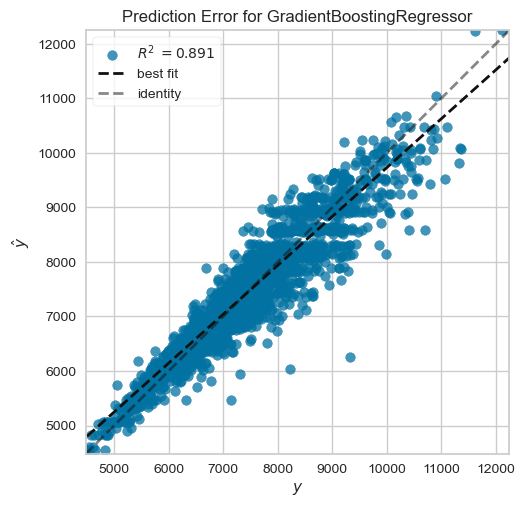

In [14]:
plot_model(best_model, plot='error')

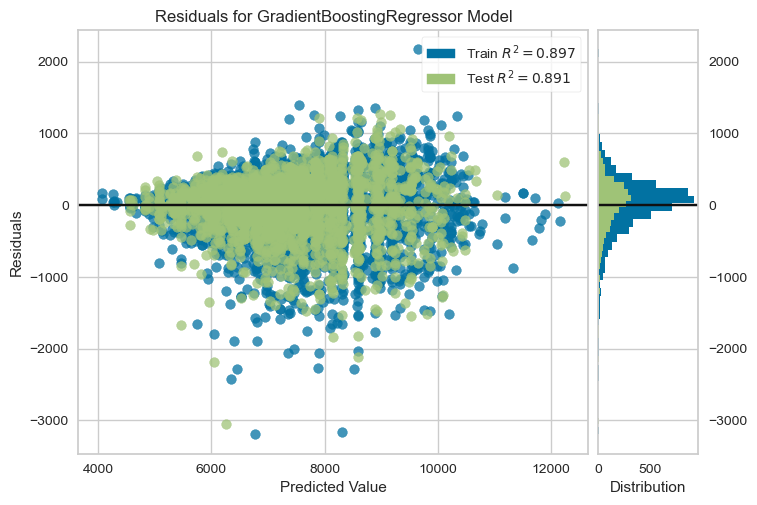

In [15]:
plot_model(best_model, plot='residuals')

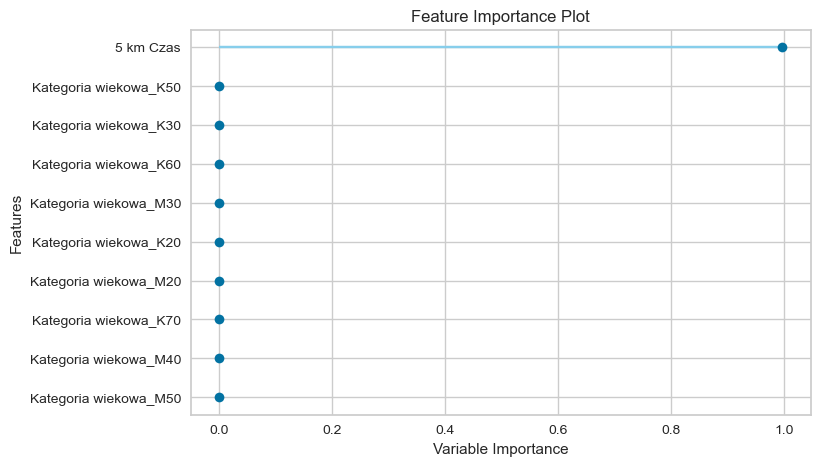

In [16]:
plot_model(best_model, plot='feature')

In [17]:
# Finalizowanie modelu
final_model = finalize_model(best_model)

In [33]:
# Lokalne zapisywanie modelu
save_model(final_model, 'hm_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Płeć', 'Kategoria wiekowa'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Płeć'],
                                     transformer=OrdinalEncoder(...
                                                                          'data_type': dtype('O'),
                                                                          'mapping': K      0
 M      1
 NaN   -1
 dtype: int64}]))),
                 ('onehot_encoding',
                  TransformerWrapper(include=['Kategoria wiekowa'],
                                     transformer=OneHotEncoder(cols=['Kategoria '
   

In [ ]:
# Umieszczenie pliku z modelem w chmurze
# s3.upload_file("hm_model.pkl", BUCKET_NAME, 'hm_model.pkl')

